# VAE Classification MNIST

In this notebook we will train the infamous Variational Auto-Encoder proposed by [Kingma and Welling 2013](https://arxiv.org/abs/1312.6114), that has formed the basis for numerous generative models available today.

In [ ]:
%%capture
%pip install lightning-uq-box

## Imports

In [24]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from lightning import LightningDataModule, Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from scipy.stats import norm
from torch import Tensor
from torchseg.encoders import TimmEncoder
from torchvision.utils import make_grid

from lightning_uq_box.uq_methods import VAE
from lightning_uq_box.uq_methods.utils import _get_num_outputs
from lightning_uq_box.viz_utils import plot_training_metrics

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed_everything(0)

Seed set to 0


0

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

The following creates a quick Datamodule for the MNIST and MNIST Fashion Dataset so that we can easily train and evaluate our model. The MNIST Fashion dataset can be used as OOD evaluation.

In [4]:
def collate_fn(batch):
    """Colate function for dataloader as dictionary."""
    images, targets = zip(*batch)
    images = torch.stack(images)
    targets = torch.tensor(targets)
    # the target is also the image, since we want to reconstruct it
    return {"input": images, "target": images, "labels": targets}


class MNISTDatamodule(LightningDataModule):
    def __init__(
        self, root: str, batch_size: int = 64, num_workers=0, resize: int = 28
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.root = root
        self.resize = resize

    def setup(self, stage: str) -> None:
        """Setup data loader."""
        if stage in ["fit", "validate"]:
            mnist_train = torchvision.datasets.MNIST(
                self.root,
                train=True,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Resize((self.resize, self.resize)),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage in ["test"]:
            self.mnist_test = torchvision.datasets.MNIST(
                self.root,
                train=False,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Resize((self.resize, self.resize)),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_val,
            batch_size=self.batch_size * 10,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.mnist_test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
        )


class MNISTFashionDatamodule(MNISTDatamodule):
    """MNIST Fashion Datamodule"""

    def setup(self, stage: str) -> None:
        """Setup data loader."""
        if stage in ["fit", "validate"]:
            mnist_train = torchvision.datasets.FashionMNIST(
                self.root,
                train=True,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Resize((self.resize, self.resize)),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )
            self.mnist_train, self.mnist_val = torch.utils.data.random_split(
                mnist_train, [55000, 5000]
            )

        if stage in ["test"]:
            self.mnist_test = torchvision.datasets.FashionMNIST(
                self.root,
                train=False,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Resize((self.resize, self.resize)),
                        torchvision.transforms.Normalize((0.1305,), (0.3081,)),
                    ]
                ),
            )

### Example Training Samples

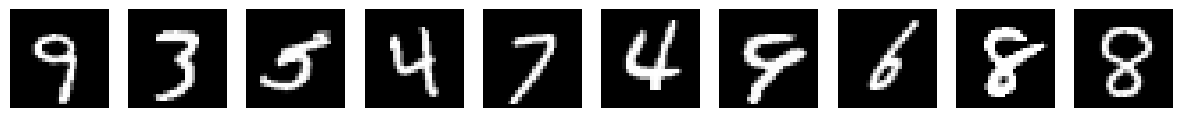

In [5]:
datamodule = MNISTDatamodule(root="./data", batch_size=64, num_workers=2)
datamodule.setup("fit")
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
images, targets = batch["input"], batch["target"]

# Number of images you want to display
num_images = 10

# Create a figure and a row of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

# Plot each image on a separate subplot
for i in range(num_images):
    axes[i].imshow(images[i, 0], cmap="gray")
    axes[i].axis("off")  # Hide axis

plt.show()

## Model and Training

The VAE implementation by default offers out-of-the box support for [torchseg encoders](https://github.com/isaaccorley/torchseg/blob/main/torchseg/encoders/timm.py). For this version, we will resample the MNIST images to 64x64 size such that we can perform enought downscaling steps in the encoder.

Later, we will also show how you can implement your custom Encoder-Decoder architecture.

In [6]:
torchseg_vae = VAE(
    encoder=TimmEncoder("mobilenetv3_small_050", depth=5, in_channels=1),
    latent_size=2,
    out_channels=1,  # MNIST are single channel grayscale images
    img_size=64,
    decoder_channels=[288, 64, 32, 16, 8, 4],
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    num_samples=5,  # Number of samples for latent sampling
)

In [7]:
torchseg_vae.encoder(torch.randn(1, 1, 64, 64))[-1].shape

torch.Size([1, 288, 2, 2])

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=40,
    accelerator="gpu",
    devices=[2],
    logger=logger,  # log training metrics for later evaluation
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)

/opt/anaconda3/envs/testUQBox/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/anaconda3/envs/testUQBox/lib/python3.10/site-pa ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
datamodule = MNISTDatamodule(root="./data", batch_size=64, num_workers=2, resize=64)
trainer.fit(torchseg_vae, datamodule)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /tmp/tmp_uf82kp9/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name                | Type             | Params
---------------------------------------------------------
0 | loss_fn             | VAELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | test_metrics        | MetricCollection | 0     
4 | encoder             | TimmEncoder      | 272 K 
5 | latent_mu           | Sequential       | 596   
6 | latent_log_var      | Sequential       | 596   
7 | latent_init_decoder | Sequential       | 888   
8 | d

## Training Metrics

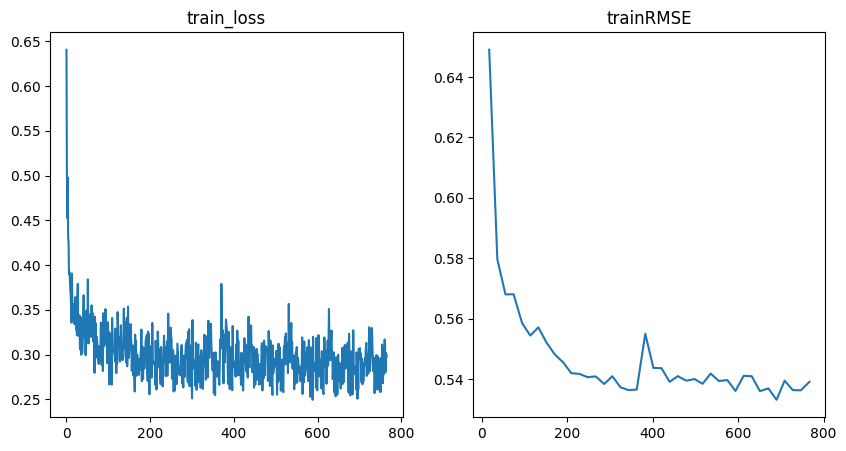

In [10]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

## Evaluation

### Reconstruction with Uncertainty

In [19]:
def plot_vae_reconstruction(batch: dict[str, Tensor], pred_dict: dict[str, Tensor]):
    """Plot VAE reconstruction results.

    Args:
        batch: Input batch from dataloader
        pred_dict: Prediction dictionary from VAE prediction step
    """
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i in range(4):
        # sample random index from batch_size
        rand_idx = np.random.randint(0, batch["input"].shape[0])
        axs[i, 0].imshow(batch["input"][rand_idx, 0], cmap="gray")
        axs[i, 0].axis("off")  # Hide axis
        axs[i, 1].imshow(pred_dict["pred"][rand_idx, 0], cmap="gray")
        axs[i, 1].axis("off")  # Hide axis
        axs[i, 2].imshow(pred_dict["pred_uct"][rand_idx, 0], cmap="gray")
        axs[i, 2].axis("off")  # Hide axis

    axs[0, 0].set_title("Input", fontsize=20)
    axs[0, 1].set_title("Reconstruction", fontsize=20)
    axs[0, 2].set_title("Uncertainty", fontsize=20)

    plt.show()

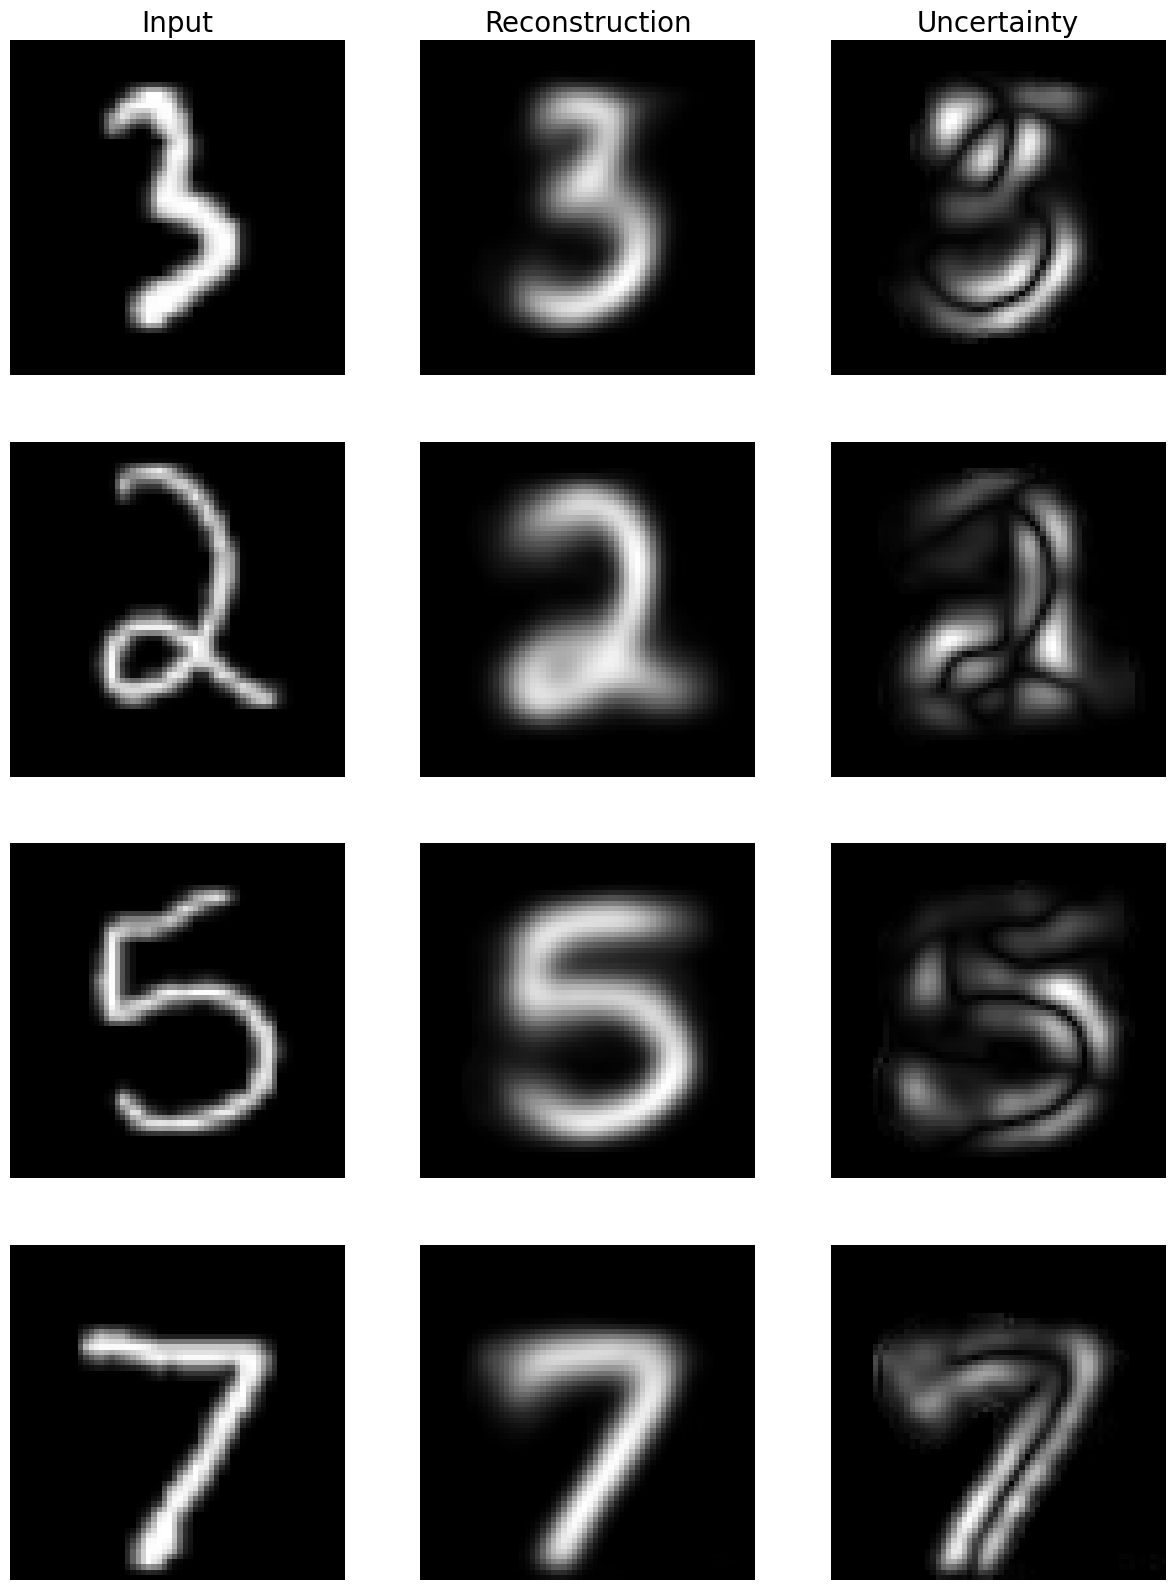

In [12]:
datamodule = MNISTDatamodule(root="./data", batch_size=64, num_workers=2, resize=64)
datamodule.setup("test")
with torch.no_grad():
    batch = next(iter(datamodule.test_dataloader()))
    pred_dict = torchseg_vae.predict_step(batch["input"])

plot_vae_reconstruction(batch, pred_dict)

### Generating samples

### Latent Space Manifold

Since we specified a `latent_size` of 2, we can try to visualize the latent space manifold to get an idea of possible interpolations or walks on the manifold space.

In [26]:
@torch.no_grad()
def visualize_manifold(model, grid_size=20):
    """Visualize the manifold of the 2D latent space.
    Args:
        model: trained VAE model
        grid_size: Number of steps/images to have per axis in the manifold.
                    Overall you need to generate grid_size**2 images, and the distance
                    between different latents in percentiles is 1/(grid_size+1)
    Returns:
        img_grid: Grid of images representing the manifold.
    """
    # obtain z values at percentiles
    percentiles = np.arange(
        0.5 / (grid_size + 1),
        (grid_size + 0.5) / (grid_size + 1),
        1.0 / (grid_size + 1),
    )
    z = norm.ppf(percentiles)

    # create list of grid_points to pass to decoder
    coordinates = []
    for y in z:
        for x in z:
            coordinates.append([x, y])

    coordinates = torch.tensor(coordinates, device=model.device, dtype=torch.float32)
    output = model.decoder_forward(coordinates)
    img_grid = make_grid(output, nrow=grid_size)

    return img_grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1321.5, 1321.5, -0.5)

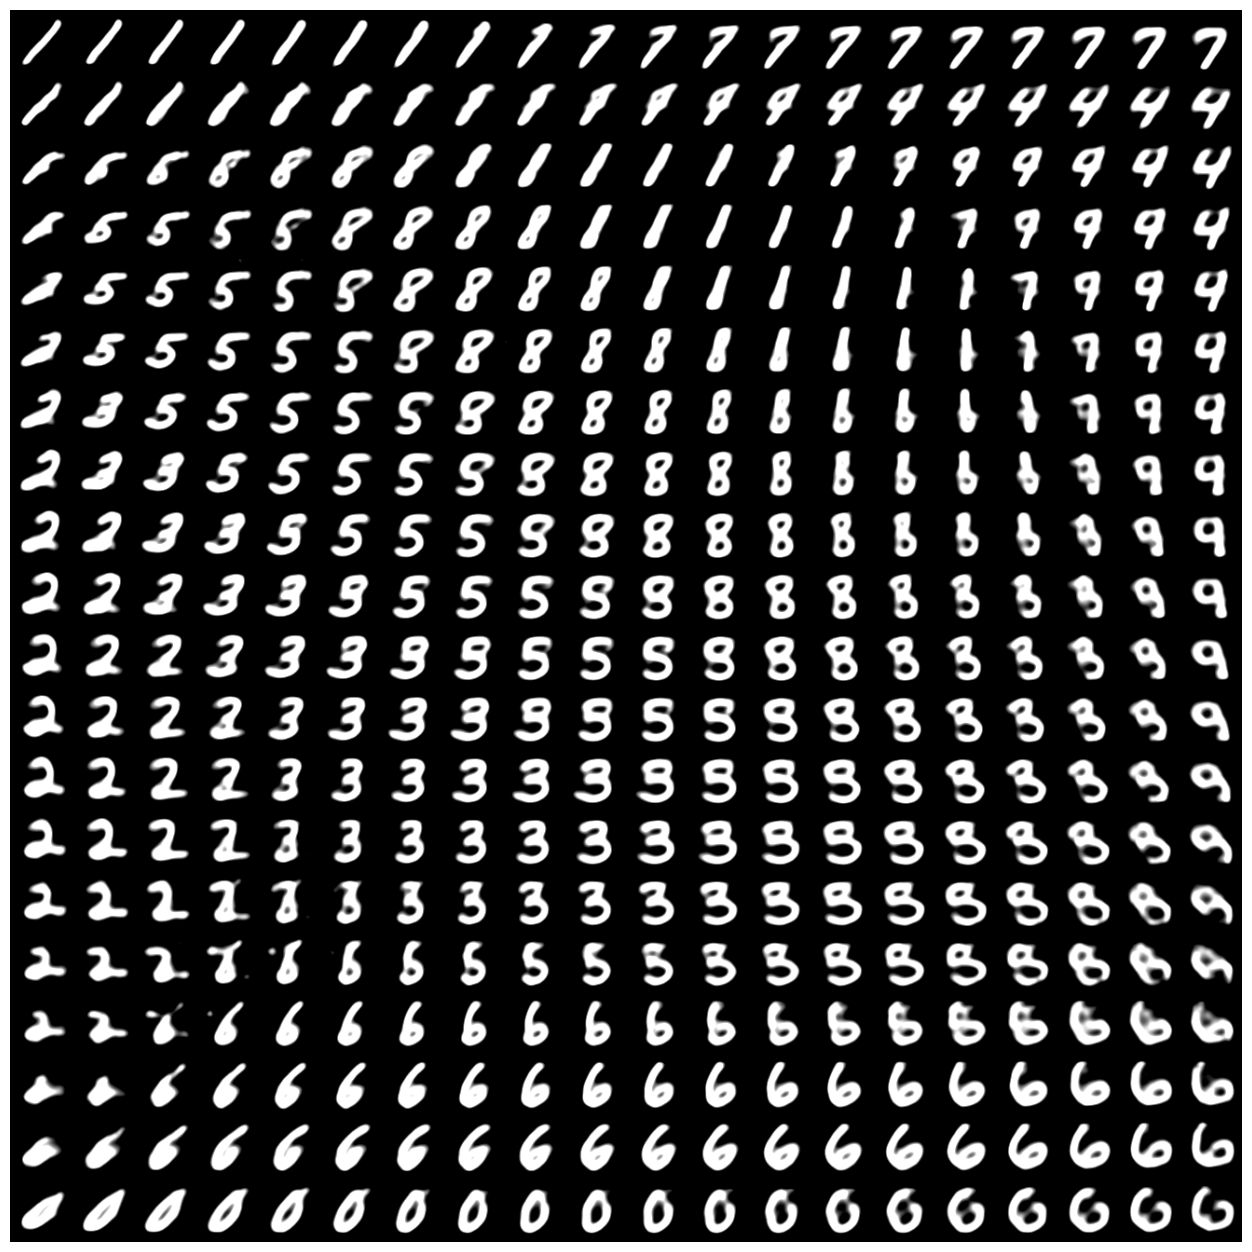

In [14]:
img_grid = visualize_manifold(torchseg_vae, grid_size=20)
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))
ax.axis("off")

### Out of Distribution

As another evaluation exercise, we can see whether the trained VAE can be applied on out-of distribution samples, in this case Fashion MNIST data.

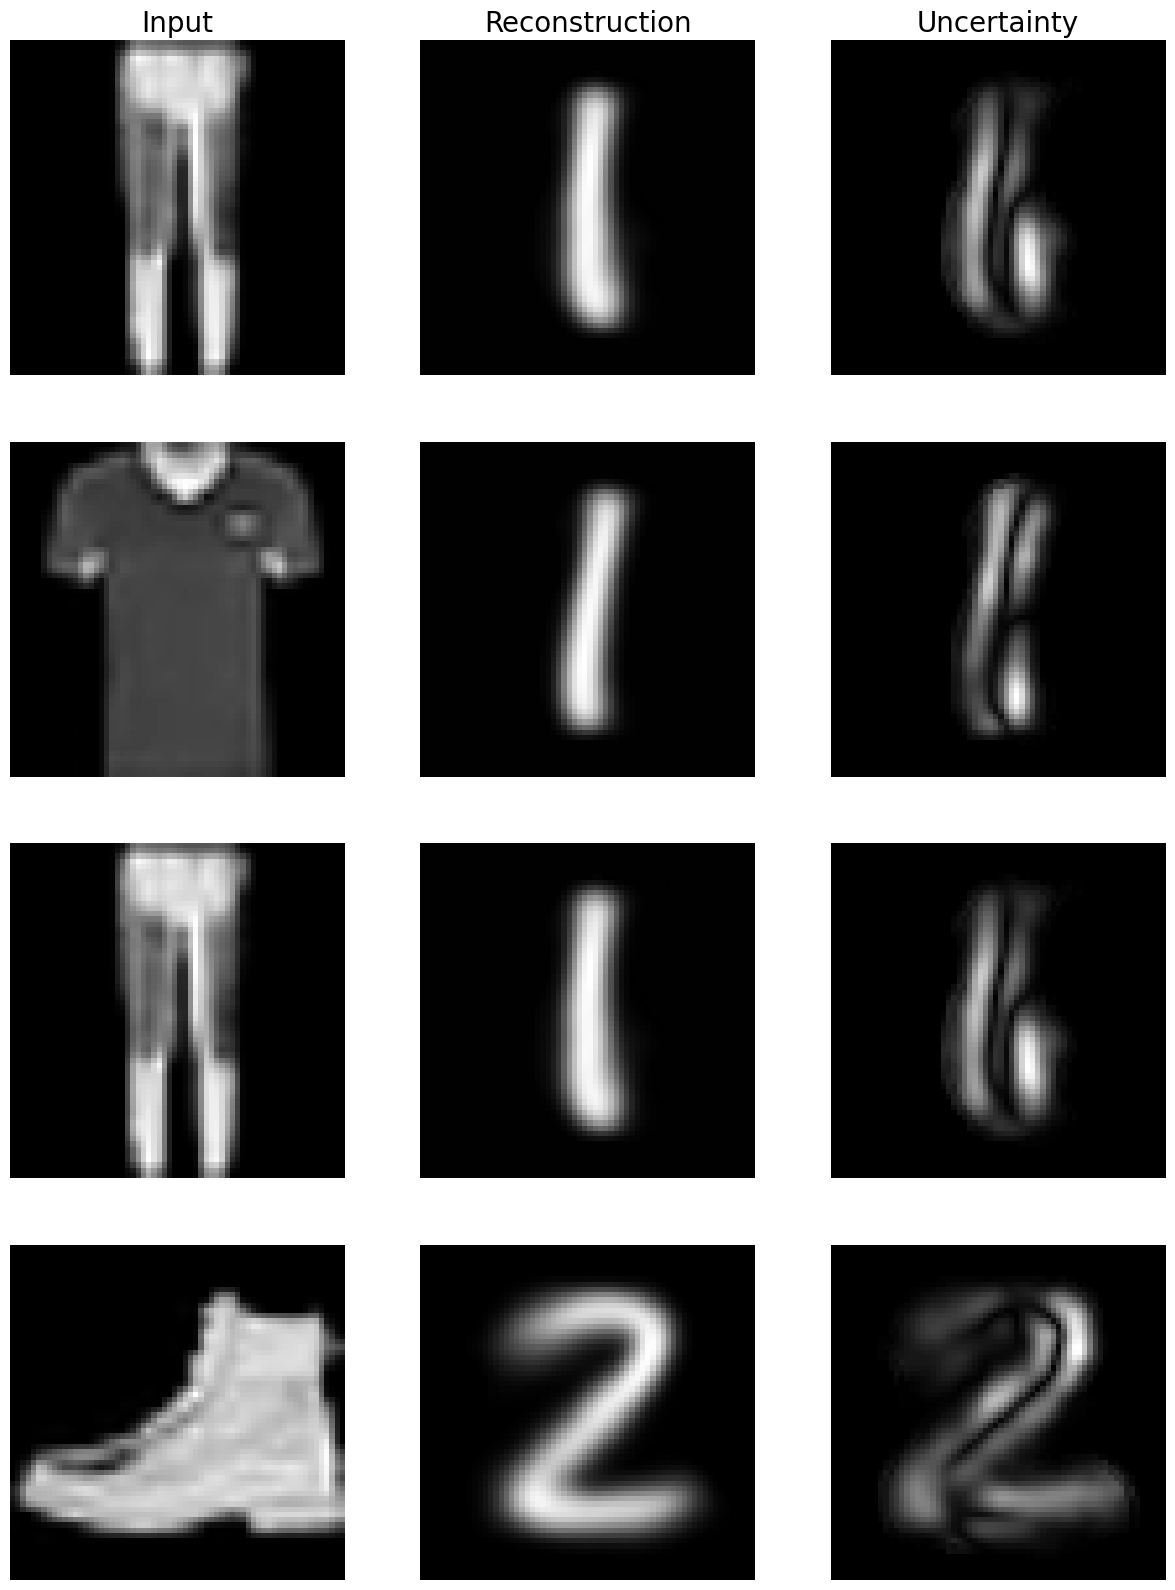

In [15]:
datamodule = MNISTFashionDatamodule(
    root="./data", batch_size=64, num_workers=2, resize=64
)
datamodule.setup("test")
with torch.no_grad():
    batch = next(iter(datamodule.test_dataloader()))
    pred_dict = torchseg_vae.predict_step(batch["input"])

plot_vae_reconstruction(batch, pred_dict)

## Custom Encoder-Decoder Model

In the following section, we will show how you can configure your custom VAE model and still use all the existing training functionality of the VAE module. For this we simply have to overwrite the `configure_model()`. Here, we will use a common MNIST Multi-Layer Perceptron (MLP) architecture for the encoder and decoder.

The parts we have to define are:
- `encoder`: an encoder model that encodes the image into a latent space
- `latent_feature_dim`: the latent feature dimensionality
- `latent_mu`: a module, that takes the output of the `encoder`and encodes the `mu` parameter of the latent space
- `latent_log_var`: a module that takes the output of the `encoder` and encodes the `log_var` parameter of the latent space
- `latent_init_decoder`(Optional): a module that decodes the latent space sample `z`such that the input shape is correct for the `decoder`
- `decoder`: a decoder model that decodes the latent space back to image space

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dims: int):
        """Initialize a new encoder.

        Args:
            latent_dims: The number of latent dimensions
        """
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass of encoder:

        Args:
            x: The input image.

        Returns:
            The latent representation.
        """
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)


class Decoder(nn.Module):
    """Decoder for VAE."""

    def __init__(self, latent_dims: int):
        """Initialize a new decoder.

        Args:
            latent_dims: The number of latent dimensions.
        """
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z: Tensor) -> Tensor:
        """Forward pass of the decoder.

        Args:
            z: The latent representation.

        Returns:
            The reconstructed image.
        """
        z = F.relu(self.linear1(z))
        z = self.linear2(z)
        return z.reshape((-1, 1, 28, 28))

In [7]:
class MyCustomVAE(VAE):
    def configure_model(self) -> None:
        """Configure the custom model."""

        self.latent_feature_dim = _get_num_outputs(self.encoder)
        self.latent_mu = nn.Linear(self.latent_feature_dim, self.latent_size)
        self.latent_log_var = nn.Linear(self.latent_feature_dim, self.latent_size)
        self.latent_init_decoder = nn.Identity()  # we will not use this

        self.decoder = Decoder(self.latent_size)

    # TimmEncoder outputs a list of features, with our custom
    # implementation we don't have that so overwrite encoding
    def encoder_forward(self, x: Tensor, cond=None) -> Tensor:
        return self.encoder(x)

In [8]:
custom_vae = MyCustomVAE(
    encoder=Encoder(latent_dims=8),
    latent_size=2,
    out_channels=1,
    img_size=28,
    optimizer=partial(torch.optim.Adam, lr=1e-3),
    num_samples=5,
)

In [16]:
my_temp_dir = tempfile.mkdtemp()
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,
    accelerator="gpu",
    devices=[2],
    logger=logger,  # log training metrics for later evaluation
    enable_progress_bar=True,
    default_root_dir=my_temp_dir,
)

/opt/anaconda3/envs/testUQBox/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/anaconda3/envs/testUQBox/lib/python3.10/site-pa ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
datamodule = MNISTDatamodule(root="./data", batch_size=128, num_workers=4)
trainer.fit(custom_vae, datamodule)

### Training Metrics

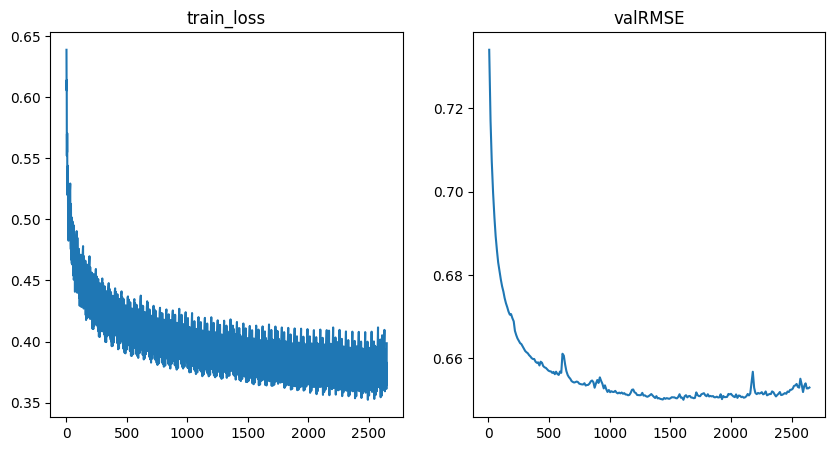

In [30]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "valRMSE"]
)

### Reconstruction with Uncertainty

We can evaluate the reconstruction quality of the VAE, together with a notion of predictive uncertainty. This uncertainty is computed as the variance over multiple decoded latent space samples that stem from the encoded image and show the areas where the model is more/less certain in their reconstruction. In the examples, we can observe that the uncertainty is usually around the digit's edges.

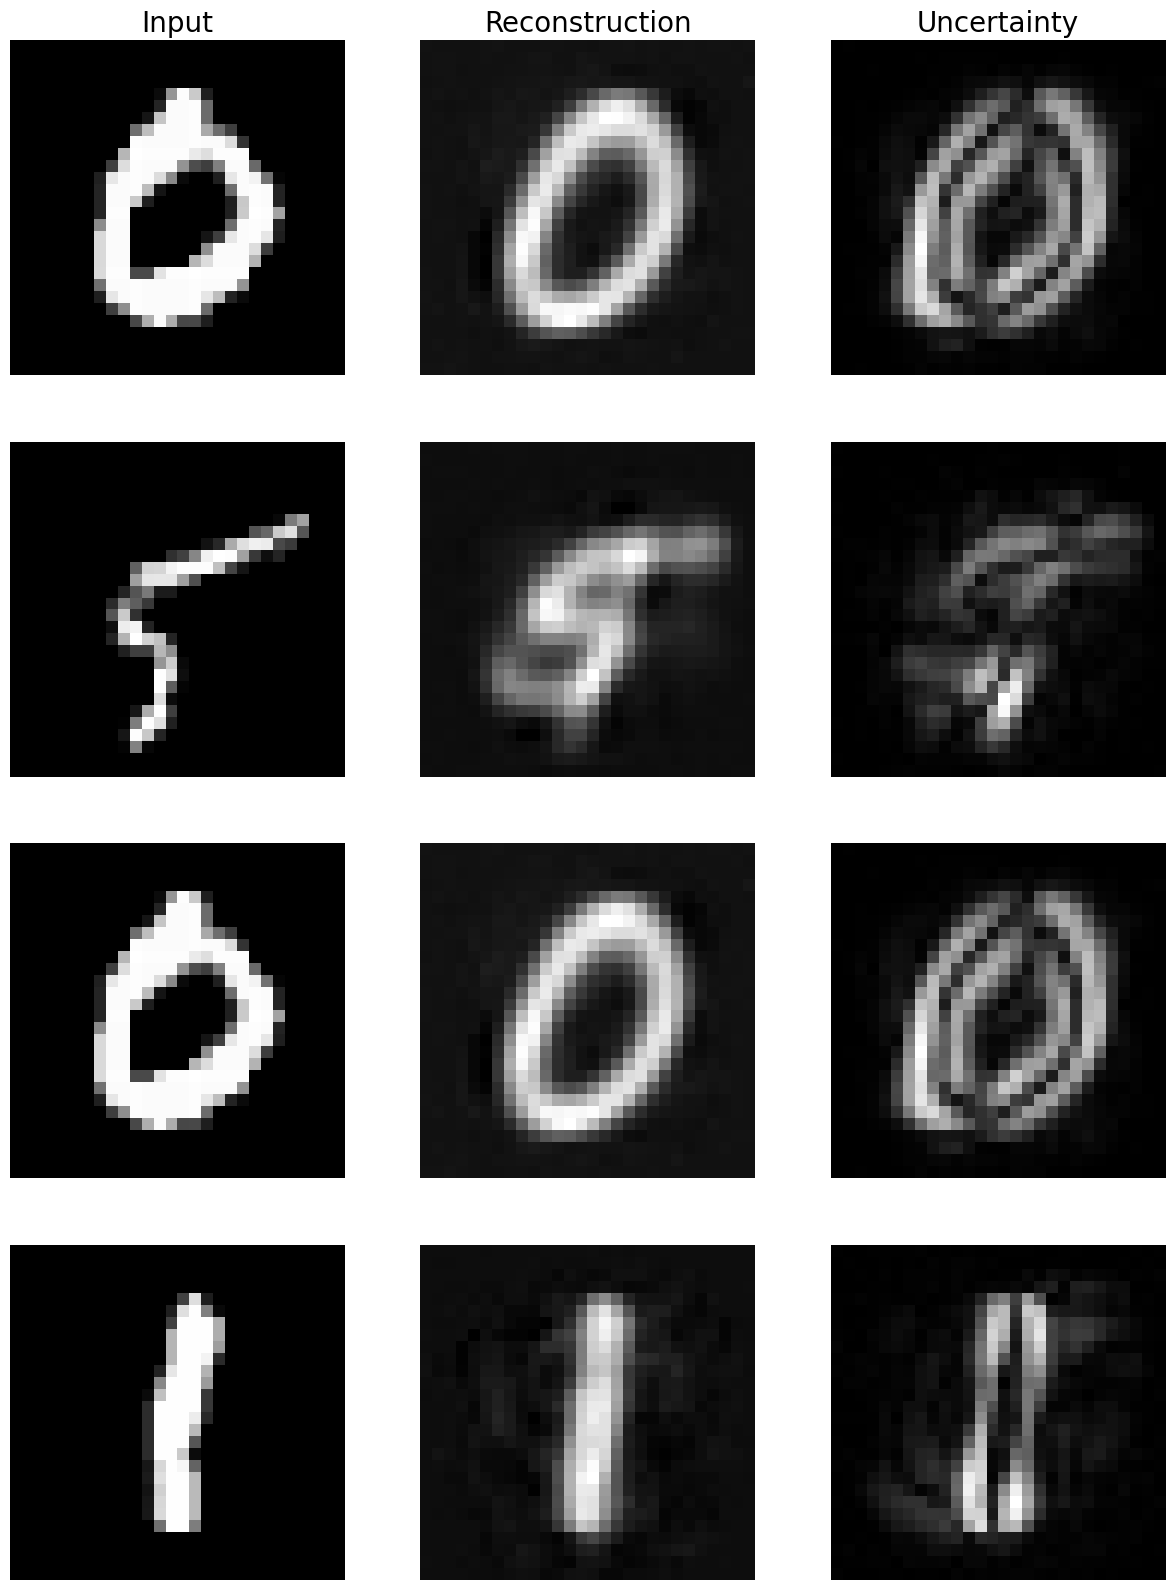

In [22]:
datamodule = MNISTDatamodule(root="./data", batch_size=64, num_workers=2)
datamodule.setup("test")
with torch.no_grad():
    batch = next(iter(datamodule.test_dataloader()))

    pred_dict = custom_vae.predict_step(batch["input"])

plot_vae_reconstruction(batch, pred_dict)

### Latent Space Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 601.5, 601.5, -0.5)

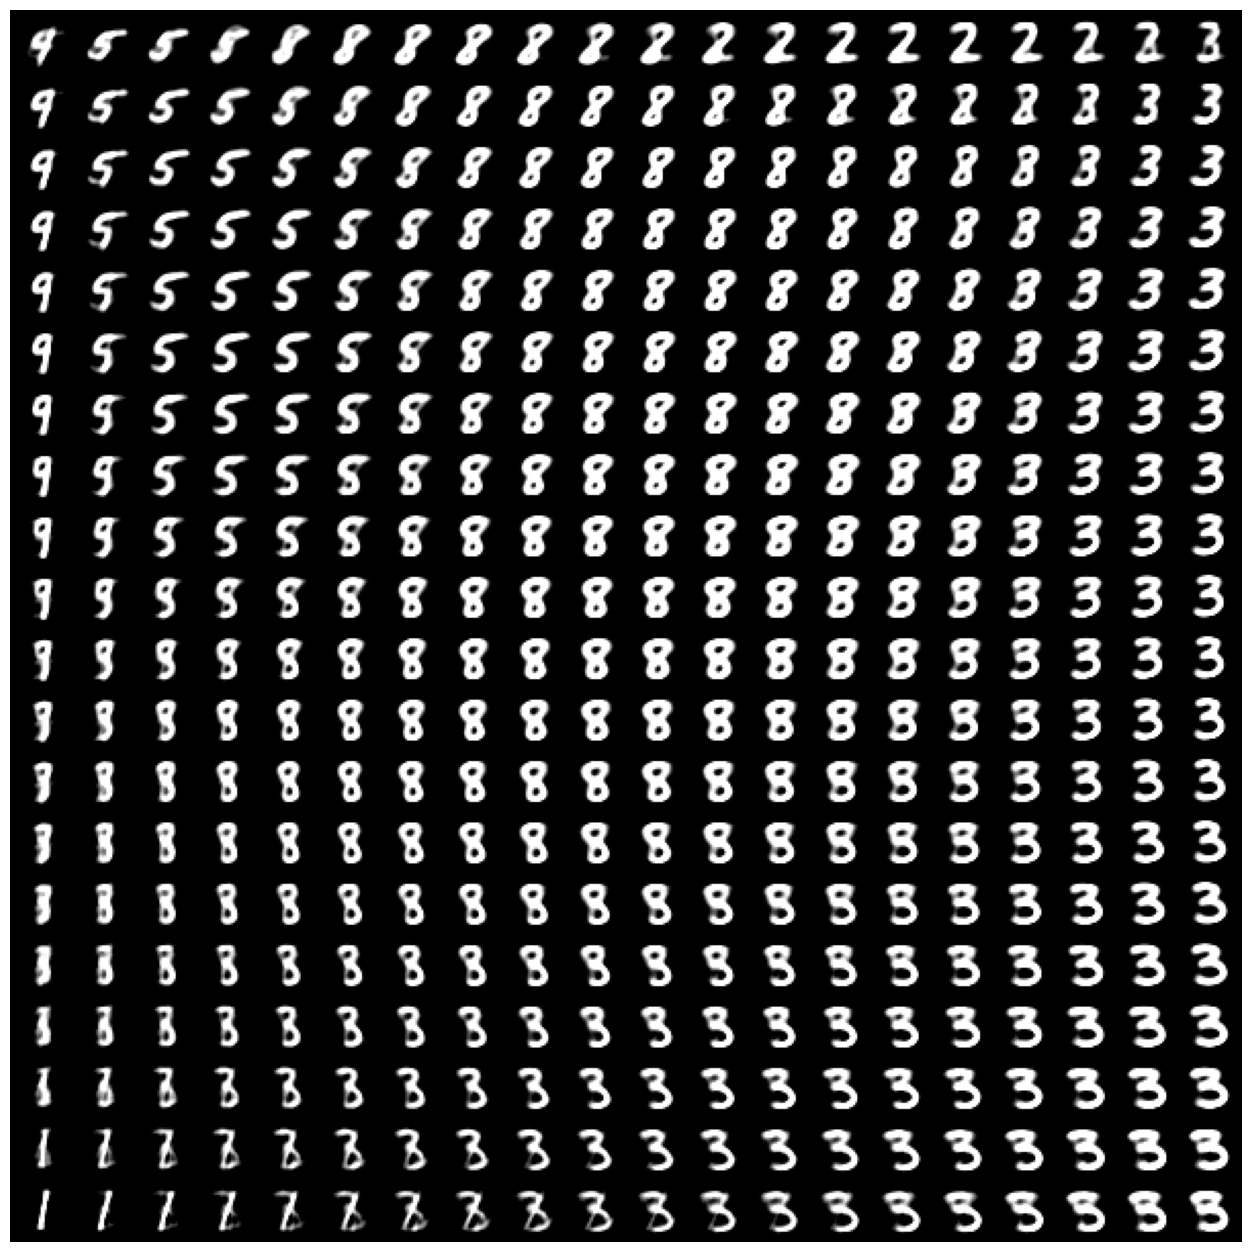

In [27]:
img_grid = visualize_manifold(custom_vae, grid_size=20)
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))
ax.axis("off")